In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

head = "/home/idies/workspace/Storage/slurvey/persistent/data analysis/data/"
models = ["FFN","FFN2","SIREN"]
tail = "_comparison_results.csv"
avg_tail = "_avg.csv"

In [26]:
def mse_to_psnr(mse, max_pixel_value):
    return 20 * np.log10(max_pixel_value) - 10 * np.log10(mse)

def get_max_value(file_path):
    data = np.load(file_path)
    return np.max(data)

def clean_data(model):
    filepath = head + model + tail
    data = pd.read_csv(filepath)
    data['original_psnr'] = np.nan
    for index, row in data.iterrows():
        max_value = get_max_value(row['file_name'])
        psnr = mse_to_psnr(row['original_mse'], max_value)
        data.at[index, 'original_psnr'] = psnr
    data = data.drop(["in_features","out_features","device"],axis=1)
    data.to_csv(head + model + tail, index=False)

In [24]:
def get_averages(df):
    columns_to_average = ['original_mse', 'compression_ratio', 'transformed_mse', 'training_time', 'original_psnr']
    group_by = ['lr', 'hidden_features', 'hidden_layers', 'max_iters']
    maybe = ["outermost_linear", "fourier_features","input_scale","weight_scale"]
    for name in maybe:
        if name in df.columns:
            group_by.append(name)
    grouped = df.groupby(group_by)[columns_to_average + ['model']].agg({
        **{col: 'mean' for col in columns_to_average},
        'model': 'first'  # This will copy the model value for each group
    }).reset_index()
    
    grouped = grouped.reset_index(drop=True)

    return grouped

def add_averages(model):
    data = pd.read_csv(head + model + tail)
    average_df = get_averages(data)
    average_df.to_csv(head + model + "_avg.csv",index=False)

In [28]:
add_averages("mixed")

In [15]:
comparison_data = {
    'Model': ['MGARD', 'SZ', 'ZFP', 'CAE', 'BCAEwoT', 'BCAE'],
    'compression_ratio': [27, 24, 19, 27, 27, 27],
    'original_mse': [626.28, 369.69, 219.48, 227.61, 230.59, 218.44],
    'PSNR': [32.23, 34.52, 36.78, 37.03, 37.06, 37.24]
}

comparisons = pd.DataFrame(comparison_data)
comparisons.set_index('Model', inplace=True)

In [319]:
comparisons

,compression_ratio,original_mse,PSNR
Model,,,
MGARD,27,626.28,32.23
SZ,24,369.69,34.52
ZFP,19,219.48,36.78
CAE,27,227.61,37.03
BCAEwoT,27,230.59,37.06
BCAE,27,218.44,37.24


In [320]:
SIREN_avg_data = pd.read_csv(head + "SIREN" + avg_tail)

In [321]:
SIREN_avg_data

,lr,hidden_features,hidden_layers,max_iters,outermost_linear,original_mse,compression_ratio,transformed_mse,training_time,original_psnr,model
0,0.0001,32,2,100,False,2016.615717,628.535744,0.078256,0.205365,27.225482,SIREN
1,0.0001,32,2,100,True,1576.581566,628.535744,0.027393,0.206415,28.248301,SIREN
2,0.0001,32,2,500,False,1565.639327,628.535744,0.026906,0.972383,28.279821,SIREN
3,0.0001,32,2,500,True,1541.322210,628.535744,0.025998,0.966230,28.342868,SIREN
4,0.0001,32,2,1000,False,1553.435394,628.535744,0.026351,1.961067,28.312303,SIREN
...,...,...,...,...,...,...,...,...,...,...,...
187,0.0010,256,4,500,True,163.546714,3.850496,0.003126,17.058640,38.133577,SIREN
188,0.0010,256,4,1000,False,7806.705329,3.850496,0.078060,34.150278,25.289283,SIREN
189,0.0010,256,4,1000,True,159.543323,3.850496,0.002953,34.121310,38.240076,SIREN
190,0.0010,256,4,2000,False,1863.312757,3.850496,0.028579,68.257073,30.082974,SIREN


In [12]:
def get_efficient_frontier(df):
    # Sort the dataframe by compression_ratio (descending) and original_mse (ascending)
    sorted_df = df.sort_values(['compression_ratio', 'original_mse'], ascending=[False, True])
    
    # Initialize the efficient frontier with the first row
    efficient_frontier = [sorted_df.iloc[0]]
    current_best_mse = sorted_df.iloc[0]['original_mse']
    
    # Iterate through the sorted dataframe
    for _, row in sorted_df.iloc[1:].iterrows():
        if row['original_mse'] < current_best_mse:
            efficient_frontier.append(row)
            current_best_mse = row['original_mse']
    
    # Create a new dataframe from the efficient frontier
    efficient_df = pd.DataFrame(efficient_frontier)
    
    return efficient_df

In [323]:
efficient_SIREN_avg = get_efficient_frontier(SIREN_avg_data)

In [324]:
efficient_SIREN_avg

,lr,hidden_features,hidden_layers,max_iters,outermost_linear,original_mse,compression_ratio,transformed_mse,training_time,original_psnr,model
103,0.0010,32,2,2000,True,1393.628588,628.535744,0.023489,3.838678,28.782150,SIREN
111,0.0010,32,3,2000,True,1228.908453,336.527937,0.020855,5.675043,29.334258,SIREN
119,0.0010,32,4,2000,True,1118.573326,229.777110,0.018928,7.526748,29.742492,SIREN
135,0.0010,64,3,2000,True,834.895781,88.523088,0.014257,9.205114,31.004186,SIREN
47,0.0001,64,4,2000,True,618.578042,59.755332,0.011152,12.233920,32.307235,SIREN
159,0.0010,128,3,2000,True,409.491812,22.721759,0.007050,20.264996,34.112529,SIREN
71,0.0001,128,4,2000,True,244.389544,15.244594,0.004529,27.543742,36.361450,SIREN
183,0.0010,256,3,2000,True,163.525762,5.757182,0.003457,48.747068,38.107865,SIREN
95,0.0001,256,4,2000,True,74.107913,3.850496,0.001932,68.054653,41.510452,SIREN


In [13]:
def plot_compression_vs_mse(df1, df2, title="Compression Ratio vs Original MSE"):
    plt.figure(figsize=(10, 6))
    
    # Plot data from the first DataFrame in blue
    plt.scatter(df1['compression_ratio'], df1['original_mse'], color='blue', label='DataFrame 1')
    
    # Plot data from the second DataFrame in red
    plt.scatter(df2['compression_ratio'], df2['original_mse'], color='red', label='DataFrame 2')
    
    plt.xlabel('Compression Ratio')
    plt.ylabel('Original MSE')
    plt.title(title)
    plt.legend()
    
    # Optional: use logarithmic scale if the values span several orders of magnitude
    # plt.xscale('log')
    # plt.yscale('log')
    
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.tight_layout()
    plt.show()

def plot_multiple_compression_vs_mse(dataframes, names, title="Compression Ratio vs Original MSE"):
    plt.figure(figsize=(12, 8))
    
    # Get a color palette with as many colors as we have dataframes
    colors = sns.color_palette(n_colors = len(dataframes))
    
    for df, name, color in zip(dataframes, names, colors):
        plt.scatter(df['compression_ratio'], df['original_mse'], 
                    color=color, label=name, alpha=0.7,s=100)
    
    plt.xlabel('Compression Ratio')
    plt.ylabel('Original MSE')
    plt.title(title)
    plt.legend()
    
    # Optional: use logarithmic scale if the values span several orders of magnitude
    #plt.xscale('log')
    #plt.yscale('log')
    
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.tight_layout()
    plt.show()

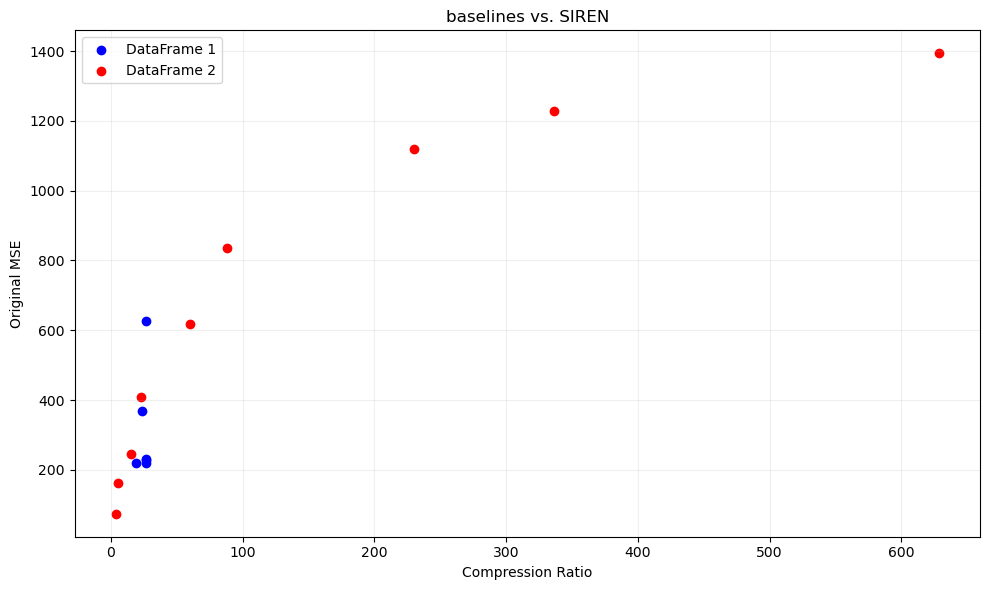

In [326]:
plot_compression_vs_mse(comparisons, efficient_SIREN_avg, "baselines vs. SIREN")

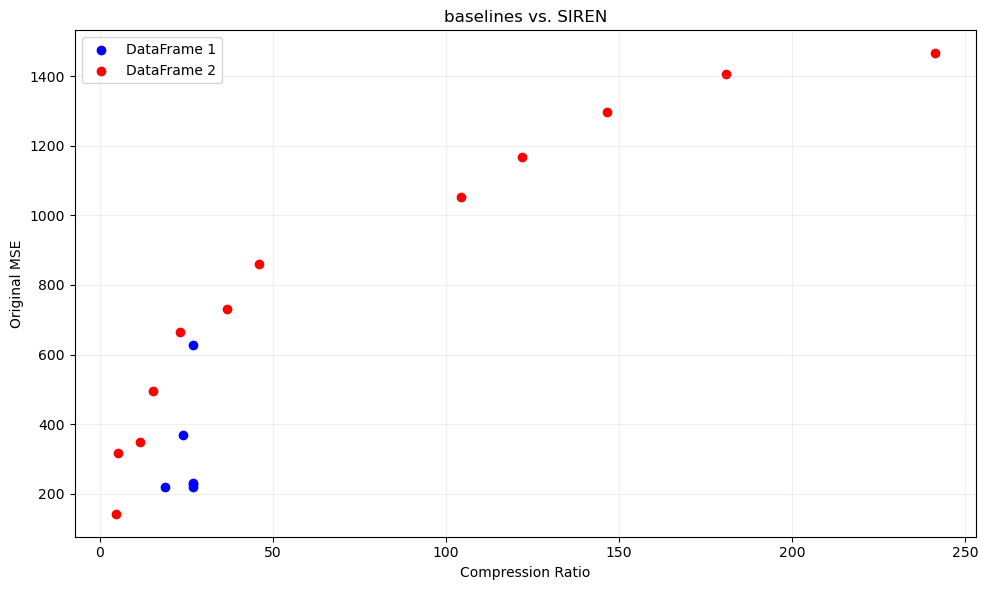

In [224]:
FFN_avg_data = pd.read_csv(head + "FFN" + avg_tail)
efficient_FFN_avg = get_efficient_frontier(FFN_avg_data)
plot_compression_vs_mse(comparisons, efficient_FFN_avg, "baselines vs. SIREN")

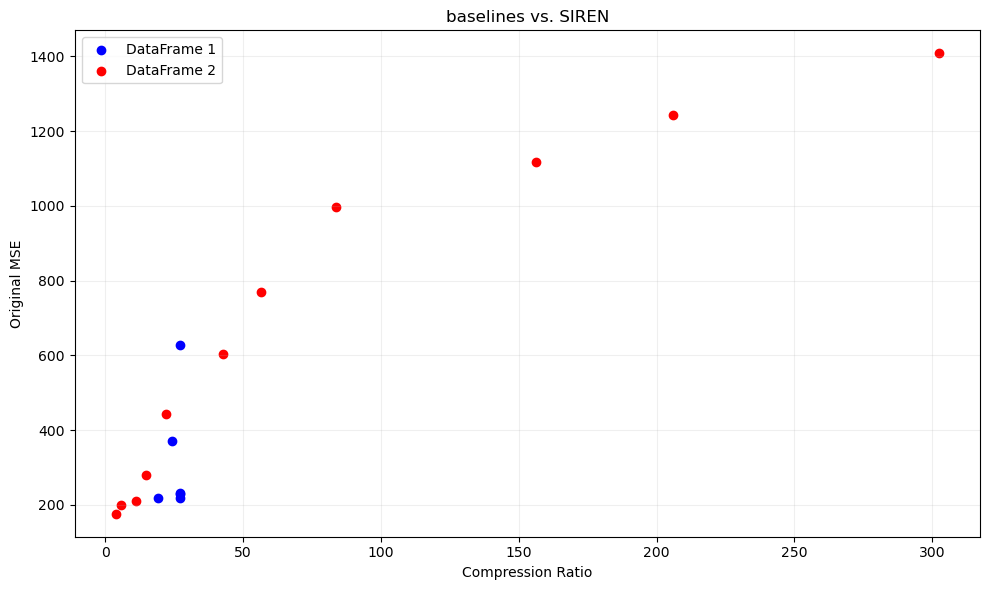

In [329]:
FFN2_avg_data = pd.read_csv(head + "FFN2" + avg_tail)
efficient_FFN2_avg = get_efficient_frontier(FFN2_avg_data)
plot_compression_vs_mse(comparisons, efficient_FFN2_avg, "baselines vs. SIREN")

In [330]:
efficient_frontiers = [efficient_SIREN_avg[(efficient_SIREN_avg['original_mse'] > 200) & (efficient_SIREN_avg['original_mse'] < 700)], efficient_FFN2_avg[(efficient_FFN2_avg['original_mse'] > 200) & (efficient_FFN2_avg['original_mse'] < 700)], comparisons]
names = ["SIREN", "FFN", "models from paper"]

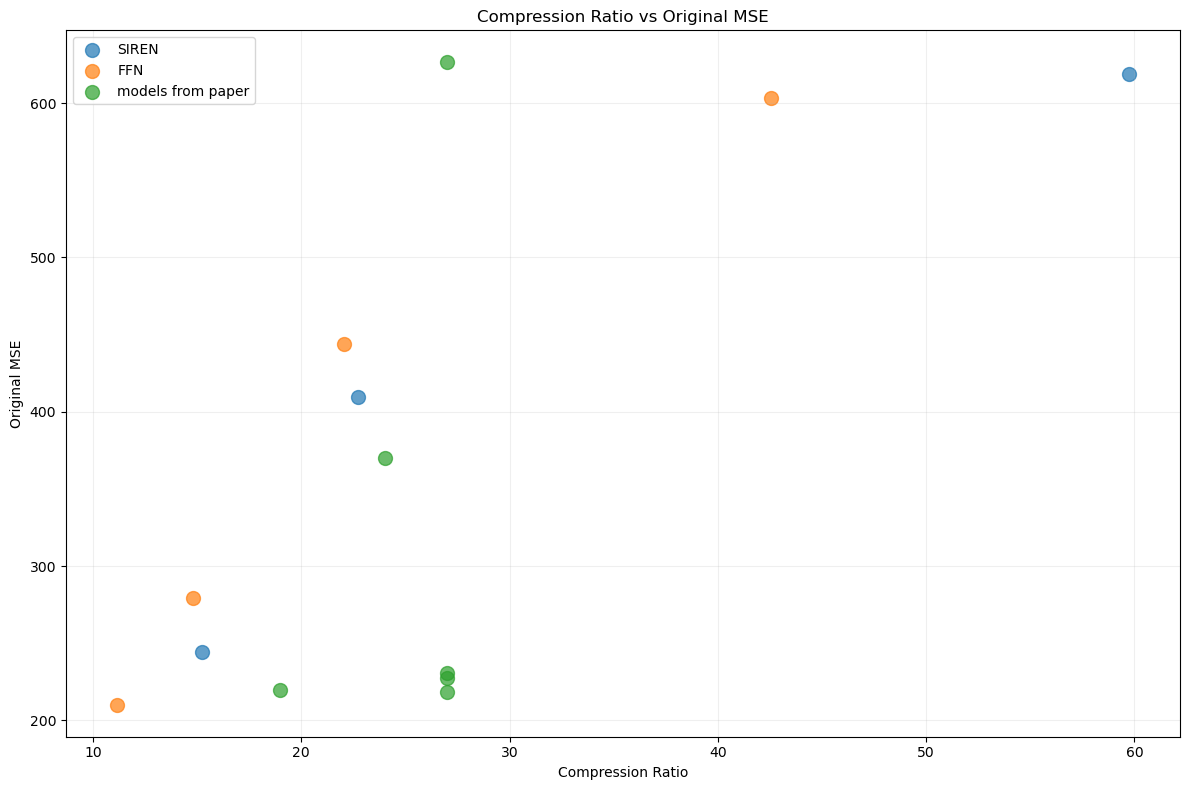

In [331]:
plot_multiple_compression_vs_mse(efficient_frontiers, names)

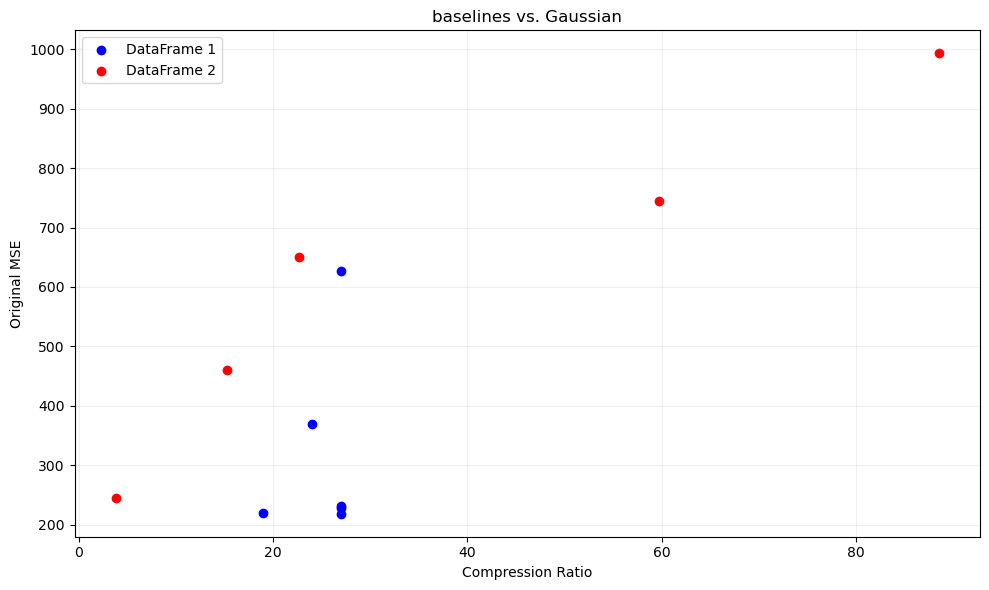

In [29]:
Gaussian_avg_data = pd.read_csv(head + "mixed" + avg_tail)
efficient_Gaussian_avg = get_efficient_frontier(Gaussian_avg_data)
plot_compression_vs_mse(comparisons, efficient_Gaussian_avg, "baselines vs. Gaussian")

In [18]:
Gaussian_avg_data

,lr,hidden_features,hidden_layers,max_iters,outermost_linear,original_mse,compression_ratio,transformed_mse,training_time,original_psnr,model
0,0.001,64,3,100,False,1576.581566,88.523088,0.029152,0.686597,28.248301,Gaussian
1,0.001,64,3,100,True,1576.581566,88.523088,0.028182,0.688224,28.248301,Gaussian
2,0.001,64,3,500,False,1576.581566,88.523088,0.027981,3.420597,28.248301,Gaussian
3,0.001,64,3,500,True,1576.581566,88.523088,0.027929,3.402635,28.248301,Gaussian
4,0.001,64,3,1000,False,1576.581566,88.523088,0.027936,6.835324,28.248301,Gaussian
5,0.001,64,3,1000,True,1576.581566,88.523088,0.027933,6.801174,28.248301,Gaussian
6,0.001,64,3,2000,False,1576.581566,88.523088,0.027832,13.663617,28.248301,Gaussian
7,0.001,64,3,2000,True,1576.581566,88.523088,0.027905,13.598457,28.248301,Gaussian
8,0.001,64,4,100,False,1576.581566,59.755332,0.028087,0.911279,28.248301,Gaussian
9,0.001,64,4,100,True,1576.581566,59.755332,0.028013,0.908561,28.248301,Gaussian
